In [22]:
%matplotlib inline 
import matplotlib.pylab as plt 
from matplotlib import lines
import numpy as np 
import seaborn as sns
sns.set_style('ticks')
default_colors = sns.color_palette()

import pandas as pd 

import CRISPR_Kinetic_model as Cas9
reload(Cas9);

import Bio
from Bio.pairwise2 import format_alignment
import copy

import sys 
sys.path.append('../code_Boyle/')
import plotting_Boyle as plt_B
reload(plt_B);

## Model prediction

In [2]:
model_id = 'init_limit_general_energies_v2'
filename = '../data/25_10_2018/median_landscape_Boyle_2Dgrid.txt'
boyle_params = np.loadtxt(filename,comments='#')

rate_to_cleave = 1

In [3]:
concentrations = [1.0,10.0,100.0,1000.0,10000.0, 1e5, 1e6]

OnTarget_clv_sweep = map(lambda x: 1.0/Cas9.calc_Time(parameters=boyle_params,
                    mismatch_positions=[],
                    model_ID=model_id,
                    rate_to_cleave=rate_to_cleave,
                    rel_conc=x/10.0), concentrations)

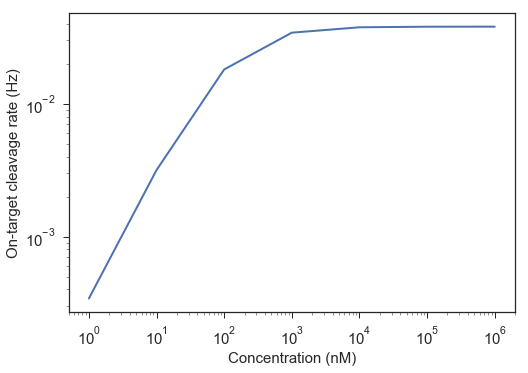

In [4]:
plt.loglog(concentrations, OnTarget_clv_sweep, lw=2)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15);
plt.xlabel('Concentration (nM)', fontsize=15)
plt.ylabel('On-target cleavage rate (Hz)', fontsize=15);

In [5]:
mm_positions = range(1,21)
TimeCLV = map(lambda x:Cas9.calc_Time(parameters=boyle_params,
                    mismatch_positions=[x],
                    model_ID=model_id,
                    rate_to_cleave=rate_to_cleave,
                    rel_conc=concentrations[-1]) , mm_positions )
TimeCLV = np.array(TimeCLV)
RelRate = (TimeCLV)**(-1)/OnTarget_clv_sweep[-1]

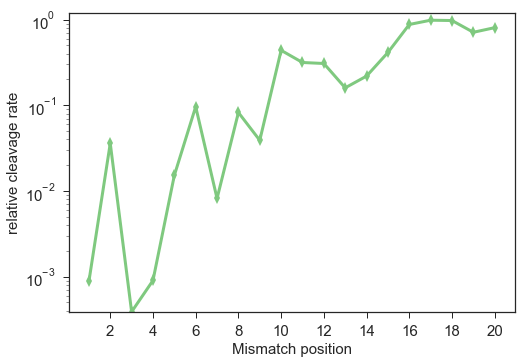

In [6]:
sns.set_palette('Accent');
plt.figure()
plt.semilogy(mm_positions,RelRate,marker='d',markersize=8,lw=3,label='Model(rel. rate)')
plt.xticks(range(2,22,2), fontsize=15);
plt.yticks([1e-3,1e-2,1e-1,1], fontsize=15);
plt.ylim([0,1.2]);
plt.xlabel('Mismatch position', fontsize=15)
plt.ylabel('relative cleavage rate', fontsize=15);
#plt.legend(fontsize=15, loc = 2);

In [7]:
RelRate

array([  8.78579024e-04,   3.59864260e-02,   3.89018434e-04,
         9.03035290e-04,   1.52010318e-02,   9.63430392e-02,
         8.17975747e-03,   8.23999521e-02,   3.90082393e-02,
         4.37993296e-01,   3.15803832e-01,   3.07453911e-01,
         1.59852032e-01,   2.19201967e-01,   4.13270748e-01,
         8.77165270e-01,   9.84043372e-01,   9.75428960e-01,
         7.11216015e-01,   8.05554300e-01])

## Ilya's data Cas9 target E

In [8]:
filename = 'ECas9_cleavage_rate_and_y0.txt'
Path = '../data_nucleaseq_Finkelsteinlab/targetE/'
Cas='Cas9'
data = pd.read_table(Path+filename, usecols=['target', 'cleavage_rate'])
data.rename(columns={'target':'Sequence'}, inplace=True)
on_target = 'TTTAGACGCATAAAGATGAGACGCTGG' 
data

,Sequence,cleavage_rate
0,TTTAGAGCGTATTTCATGAGACGCTGG,2.657239e-06
1,TTTAGACTGCGATAAAGATGAGACGCTGG,2.767674e-22
2,TTTAGACGCATAAAGATGAGACGCCTTAA,1.199120e-06
3,TTTAGACGCATAAAGATGAGACGCTAGGA,5.308185e-05
4,TTTAGACGTCAGTAAAGATGAGACGCTGG,8.747661e-25
5,GTTAGACGCAAAAAGATGAGACGCTGG,6.562247e-03
6,TTTAGATGCATAAAGATGAGGCGCTGG,5.423274e-04
7,TTTAGACGCATAAAGATGAGACGCTGG,1.824571e-01
8,TTATCTGCGTATTTCTACTCTGCGACC,8.303863e-28
9,TTTAGACGCATAAACTACTCTGCCTGG,1.056168e-22


In [9]:
def separate_PAM(S, Cas='Cas9'):
    
    if Cas == 'Cas9':
        PAM_len =3
        PAM = S[-PAM_len:]
        s = S[0:-PAM_len]
        s = s[::-1]
        s = s[0:-4]
        canonical = False
        if PAM[1:]=='GG':
            canonical = True
    if Cas == 'Cas12a':
        PAM_len = 4
        PAM = S[:PAM_len]
        s = S[PAM_len:]
        s = s[0:-3]
        canonical = False
        if (PAM[:3]=='TTT')&(PAM[3]!='T'):
            canonical = True
    return PAM, s, canonical

def find_length_diff(S, on_target, Cas='Cas9'):
    
    _, s, _ = separate_PAM(S, Cas)
    _, t, _ = separate_PAM(on_target, Cas='Cas9')
    return len(s)-len(t)

def Allign(S, on_target, Cas):
    
    _, s, _ = separate_PAM(S, Cas)
    _, t, _ = separate_PAM(on_target, Cas)
    A = Bio.pairwise2.align.globalxx(t, s)
    if len(s)==len(t):
        MM_num = np.sum(np.array(list(t))==np.array(list(s)))
        a = (t,s,MM_num,0,len(t))
        if a not in A:
            A.append(a)
    
    return A

In [10]:
data['On Target'] = data['Sequence'] == on_target
data['PAM'] = data['Sequence'].apply(lambda S: separate_PAM(S, Cas)[0])
data['Canonical'] = data['Sequence'].apply(lambda S: separate_PAM(S, Cas)[2])
data['Length difference'] = data['Sequence'].apply(lambda S: find_length_diff(S, on_target, Cas))
data['Alignment_raw'] = data['Sequence'].apply(lambda S: Allign(S, on_target, Cas))


In [11]:
def Clean_allignment(x):
    A = copy.deepcopy(x['Alignment_raw'])
    Length_diff = x['Length difference']

    if Length_diff == 0:
        function_to_filter = lambda a: not(('-' in a[0]) or ('-' in a[1]))
        A = filter(function_to_filter, A)
        return A
    
    if Length_diff > 0:
        function_to_filter = lambda a: not(('-' not in a[0]) or ('-' in a[1]))
        A = filter(function_to_filter, A)
        id_for_sort = lambda a: '|'.join(map(lambda x: str(x), list(np.arange(1,len(a[0])+1)[np.array(list(a[0])) != np.array(list(a[1]))])))
        if len(A)>1:        
            A.sort(key=id_for_sort, reverse=True)
            del A[1:]
        return(A)
    
    if Length_diff < 0:
        function_to_filter = lambda a: not(('-' in a[0]) or ('-' not in a[1]))
        A = filter(function_to_filter, A)
        id_for_sort = lambda a: '|'.join(map(lambda x: str(x), list(np.arange(1,len(a[0])+1)[np.array(list(a[0])) != np.array(list(a[1]))])))
        if len(A)>1:        
            A.sort(key=id_for_sort, reverse=True)
            del A[1:]
        return(A)



In [12]:
data['Alignment_selected'] = data.apply(Clean_allignment, axis=1)
data['Alignment'] = data['Alignment_selected'].apply(lambda A: format_alignment(*A[0]).split('S')[0] if len(A) > 0 else '')
data['Alignment (All)'] = data['Alignment_raw'].apply(lambda A: ('\n').join(map(lambda a: format_alignment(*a).split('S')[0], A)) if len(A)>0 else '')

In [13]:
def Make_Mutation_ID(x):
    
    if len(x['Alignment_selected']) == 0:
        return ''
    
    Length_diff = x['Length difference']
    a = x['Alignment_selected'][0]

    if Length_diff > 0:
        ta = np.array(list(a[0]))
        sa = np.array(list(a[1]))
        All_positions = np.arange(1,len(sa)+1)
        Mut_positions_on_s = All_positions[ta!=sa]
        Mut_Seqs = sa[[ta!=sa]]
        Mut_types = np.array(['i']*len(Mut_Seqs))
        Mut_Seqs_on_t = ta[[ta!=sa]]
        Mut_types[Mut_Seqs_on_t!='-'] = 'r'
        offset = np.zeros(len(Mut_types), dtype=int)
        for n in range(len(offset)):
            offset[n] = np.sum(Mut_types[0:n]=='i')
        # For insertion it gives the position of a base on the target before which there is an insertion.
        Mut_positions = Mut_positions_on_s - offset 
        ID_list = []
        for Mut_type, Mut_pos, Mut_Seq in zip(Mut_types, Mut_positions, Mut_Seqs):
            ID_list.append(':'.join([Mut_type, str(Mut_pos), Mut_Seq]))
        ID_list = filter(lambda x: 'i:21' not in x[:-2], ID_list) # Insertion after position 20 does not count.
        ID = '|'.join(ID_list)

    if Length_diff < 0:
        ta = np.array(list(a[0]))
        sa = np.array(list(a[1]))
        All_positions = np.arange(1,len(ta)+1)
        Mut_positions = All_positions[ta!=sa]
        Mut_Seqs = ta[[ta!=sa]]
        Mut_types = np.array(['d']*len(Mut_Seqs))
        Mut_Seqs_on_s = sa[[ta!=sa]]
        Mut_types[Mut_Seqs_on_s!='-'] = 'r'
        ID_list = []
        for Mut_type, Mut_pos, Mut_Seq in zip(Mut_types, Mut_positions, Mut_Seqs):
            ID_list.append(':'.join([Mut_type, str(Mut_pos), Mut_Seq]))
        ID = '|'.join(ID_list)

    if Length_diff == 0:
        ta = np.array(list(a[0]))
        sa = np.array(list(a[1]))
        All_positions = np.arange(1,len(ta)+1)
        Mut_positions = All_positions[ta!=sa]
        Mut_Seqs = sa[[ta!=sa]]
        Mut_types = np.array(['r']*len(Mut_Seqs))
        ID_list = []
        for Mut_type, Mut_pos, Mut_Seq in zip(Mut_types, Mut_positions, Mut_Seqs):
            ID_list.append(':'.join([Mut_type, str(Mut_pos), Mut_Seq]))
        ID = '|'.join(ID_list)
    
    return ID

In [14]:
data['Mutation ID'] = data.apply(Make_Mutation_ID, axis=1)
data['Mutation Type'] = data['Mutation ID'].apply(lambda x: '|'.join(map(lambda y: y[0], x.split('|'))) if x!='' else '')
data['Mutation Count'] = data['Mutation Type'].apply(lambda x: len(x.split('|')) if x!='' else np.NaN)

In [15]:
data = data[['Sequence', 'On Target', 'PAM', 'Canonical', 'Length difference', 'Alignment', 'Alignment (All)', 
             'Mutation ID', 'Mutation Type', 'Mutation Count', 'cleavage_rate']]
data

,Sequence,On Target,PAM,Canonical,Length difference,Alignment,Alignment (All),Mutation ID,Mutation Type,Mutation Count,cleavage_rate
0,TTTAGAGCGTATTTCATGAGACGCTGG,False,TGG,True,0,CGCAGAGTAGAAATACGCAG\n||||||||||||||||||||\nCG...,CGCAGAGTAGAAA-T--AC-GC-AG\n|||||||||||||||||||...,r:10:C|r:11:T|r:12:T|r:13:T|r:14:A|r:15:T|r:16...,r|r|r|r|r|r|r|r|r,9.0,2.657239e-06
1,TTTAGACTGCGATAAAGATGAGACGCTGG,False,TGG,True,2,CGCAGAGTAGAAATA-CG-CAG\n||||||||||||||||||||||...,CGCAGAGTAGAAATA-CG-CAG\n||||||||||||||||||||||...,i:16:G|i:18:T,i|i,2.0,2.767674e-22
2,TTTAGACGCATAAAGATGAGACGCCTTAA,False,TAA,False,2,-C-GCAGAGTAGAAATACGCAG\n||||||||||||||||||||||...,-C-GCAGAGTAGAAATACGCAG\n||||||||||||||||||||||...,i:1:T|i:2:C,i|i,2.0,1.199120e-06
3,TTTAGACGCATAAAGATGAGACGCTAGGA,False,GGA,False,2,--CGCAGAGTAGAAATACGCAG\n||||||||||||||||||||||...,--CGCAGAGTAGAAATACGCAG\n||||||||||||||||||||||...,i:1:A|i:1:T,i|i,2.0,5.308185e-05
4,TTTAGACGTCAGTAAAGATGAGACGCTGG,False,TGG,True,2,CGCAGAGTAGAAAT-AC-GCAG\n||||||||||||||||||||||...,CGCAGAGTAGAAAT-AC-GCAG\n||||||||||||||||||||||...,i:15:G|i:17:T,i|i,2.0,8.747661e-25
5,GTTAGACGCAAAAAGATGAGACGCTGG,False,TGG,True,0,CGCAGAGTAGAAATACGCAG\n||||||||||||||||||||\nCG...,CGCAGAGTAGAAATA-CGCAG\n|||||||||||||||||||||\n...,r:14:A,r,1.0,6.562247e-03
6,TTTAGATGCATAAAGATGAGGCGCTGG,False,TGG,True,0,CGCAGAGTAGAAATACGCAG\n||||||||||||||||||||\nCG...,CGCAG-AGTAGAAATACGC-AG\n||||||||||||||||||||||...,r:4:G|r:18:T,r|r,2.0,5.423274e-04
7,TTTAGACGCATAAAGATGAGACGCTGG,True,TGG,True,0,CGCAGAGTAGAAATACGCAG\n||||||||||||||||||||\nCG...,CGCAGAGTAGAAATACGCAG\n||||||||||||||||||||\nCG...,,,NaN,1.824571e-01
8,TTATCTGCGTATTTCTACTCTGCGACC,False,ACC,False,0,CGCAGAGTAGAAATACGCAG\n||||||||||||||||||||\nGC...,CGCAGAGTAGAAA-T-A-C-----GCAG--\n||||||||||||||...,r:1:G|r:2:C|r:3:G|r:4:T|r:5:C|r:6:T|r:7:C|r:8:...,r|r|r|r|r|r|r|r|r|r|r|r|r|r|r|r|r|r|r|r,20.0,8.303863e-28
9,TTTAGACGCATAAACTACTCTGCCTGG,False,TGG,True,0,CGCAGAGTAGAAATACGCAG\n||||||||||||||||||||\nCC...,CGCAGAGT---AG--AAATACGCAG\n|||||||||||||||||||...,r:2:C|r:3:G|r:4:T|r:5:C|r:6:T|r:7:C|r:8:A|r:9:...,r|r|r|r|r|r|r|r|r,9.0,1.056168e-22


In [16]:
data_1mm = data[data['Canonical']&(data['Mutation Count']==1)&(data['Length difference']==0)&(data['Mutation Type']=='r')]
data_1mm = data_1mm[['Mutation ID','cleavage_rate']]
data_1mm['MM_pos'] = data_1mm['Mutation ID'].apply(lambda x: int(x.split(':')[1]))

In [17]:
data_1mm_median = data_1mm[['MM_pos', 'cleavage_rate']].groupby('MM_pos').median().reset_index()
data_1mm_median

,MM_pos,cleavage_rate
0,1,0.000368
1,2,0.003063
2,3,0.001064
3,4,0.000467
4,5,0.001861
5,6,0.000409
6,7,0.000351
7,8,0.021025
8,9,0.004874
9,10,0.018575


In [18]:
data_OT = data[data['On Target']]
data_OT = data_OT[['Sequence', 'cleavage_rate']]
OT_cleavage_rate = data_OT['cleavage_rate'].median()
OT_cleavage_rate

0.1454226619125

In [28]:
sns.set_palette('Accent');

simset = []
no_good = []

chi_squared = [] 

#---------- collect simulations ---------------
for sim in range(1,51) + range(101,151):
    sa = pd.read_csv('../data/25_10_2018/fit_25_10_2018_sim_' +str(sim)+'.txt', delimiter='\t', index_col=46)
    filename = '../data/25_10_2018/fit_25_10_2018_sim_' +str(sim) +'.txt'   
    chi_squared.append(sa.Potential.iloc[-1])
    simset.append(filename)
    
for sim in range(11,21):
    sa = pd.read_csv('../data/19_10_2018/fit_19_10_2018_sim_' +str(sim)+'.txt', delimiter='\t', index_col=46)
    filename = '../data/19_10_2018/fit_19_10_2018_sim_' +str(sim) +'.txt'
    chi_squared.append(sa.Potential.iloc[-1])
    simset.append(filename)


model_id = 'init_limit_general_energies_v2'
Nparams = 44
rate_to_cleave = 10**4
count = 1
for sim in simset:
    count +=1 
    plt.figure()
    parameters = plt_B.load_simm_anneal(sim, Nparams)
    
    mm_positions = range(1,21)
    TimeCLV = map(lambda x:Cas9.calc_Time(parameters,
                        mismatch_positions=[x],
                        model_ID=model_id,
                        rate_to_cleave=rate_to_cleave,
                        rel_conc=concentrations[-1]) , mm_positions )
    TimeCLV = np.array(TimeCLV)
    Rate = (TimeCLV)**(-1)
    plt.semilogy(mm_positions,Rate,marker='d',markersize=8,lw=3,label='model')


    plt.semilogy(data_1mm_median['MM_pos'], data_1mm_median['cleavage_rate']/1.0,
        marker='s', markersize=8,lw=3,label='data')
    plt.xticks(range(2,22,2), fontsize=15);
    plt.yticks([1e-3,1e-2,1e-1,1], fontsize=15);
    plt.ylim([0,1.2]);
    plt.xlabel('Mismatch position', fontsize=15)
    plt.ylabel('relative cleavage rate', fontsize=15);
    plt.legend(fontsize=15, loc = 2);
    plt.savefig('check/'+str(count)+'.pdf', format='pdf',bbox_inches='tight');
    plt.close()

